In [31]:


from PIL import Image

import os
from os.path import split,join, isdir ,exists
os.chdir('/home/DISCOVER_summer2022/xusc/exp/Cerberus-main')
from loguru import logger
import torch
import numpy as np
import skimage
from torchvision.transforms import transforms
import matplotlib.pyplot as plt
from PIL import Image

from utils import *
plt.rcParams['savefig.dpi'] = 200 #图片像素
plt.rcParams['figure.dpi'] = 200 #分辨率
# import matplotlib as mpl
# mpl.rcParams.update(mpl.rcParamsDefault)



from dataloaders.datasets.sbu import SBU

from plot.plot_utils import *



In [32]:



class SBUQualitativeSelector:

    def __init__(self,path,model_name, dataset =None , save_dir = None):

        self.name  = model_name 

        self.root  = path 

        self.task = 'illumination'

        

        #todo 
        if dataset is None :
            self.dataset  =   SBU(path='data/SBU/SBU-shadow',subset='val')

            print(f'dataset is loaded ')
        else :
            self.dataset  = dataset
        
        if save_dir is None : 
            self.save_dir = join('logs/sbu',model_name)
        else:
            self.save_dir = save_dir

        make_dir(self.save_dir)


        
        self.COLORS = {
            "TP":(20,255,10),
            "FN":(255,10,10),#* 蓝色
            "FP":(251,254,3),
        }
    
        # todo  export name list from matlab program 
        self.name_list = np.loadtxt('data/SBU/SBU-shadow/SBU-Test/matlab_load_sequence.txt',dtype=np.str0,delimiter='\n')

        
        self.illumination  =self.get_images_quantitative_results(self.task)

    def __len__(self):
        return  len(self.name_list)
    


    def get_images_quantitative_results(self,task):
        
        return np.loadtxt(join(self.root,task,'nms-eval','eval_bdry_img.txt'))

        

    def get_origin_data(self,idx):
        name = self.name_list[idx]
        
        
        image,gt_edge_map  = self.dataset.getitem(self.dataset.name2idx(name+".jpg"))
        # print(np.unique(gt_edge_map),gt_edge_map.shape)

        gt_edge_map = gt_edge_map/255
        return image,gt_edge_map 

    def getitem(self,idx):
        name = self.name_list[idx]
        image,gt_edge_map = self.get_origin_data(idx)
        image = image[:,:,::-1]

    
        prediction_edge  = imread(join(self.root,self.task,'nms',self.name_list[idx]+'.png'),gray=True)

        return image,prediction_edge,name

    def get_name(self):
        return self.name
    
    def name2idx(self,name):

        return np.where(self.name_list == name)[0][0]
    

    def get_F_quantitatives(self,index):
        name = self.name_list[index]
        illumination = self.illumination[index][-1]
        return illumination,name


    def get_best_image(self):
        ans = {}
        for idx in range(self.__len__()):

            ans[self.name_list[idx]] = self.get_F_quantitatives(idx)

        return  sorted(ans.items(), key =lambda k : k[1])[::-1]
    
    
    def draw_edge(self,idx,threshold_range = np.arange(0.5,1,0.1)):


        image,prediction_edge,name = self.getitem(idx)#* 0-255 map 
        
        name_format = "%s_%d.png"
        save_dir = join(self.save_dir)
        make_dir(save_dir)
        

        
        __,gt_edge =self.get_origin_data(idx)
        

        
        ans=[]
        for threshold in threshold_range:

            save_name = join(save_dir, name_format%(name,threshold*100))
            
            # if exists(save_name):
            #     return [imread(save_name)[:,:,::-1]]

            image_drawed = image.copy()

            filter_pred_edge = (prediction_edge>threshold*255)

            #* FP
            image_drawed [(gt_edge==0) & ( filter_pred_edge ==1)] = self.COLORS['FP']

            #* FN
            image_drawed[(gt_edge==1)  &  (filter_pred_edge ==0)] = self.COLORS['FN']

            
            
            dilation_times  = 2
            filter_pred_edge = dilation(filter_pred_edge,times=dilation_times)/255
            
            #* TP
            image_drawed[(gt_edge == 1 ) &  (filter_pred_edge==1)] = self.COLORS['TP']
            

            show_imgs([image_drawed],[0],img_name=save_name)
            
            ans.append(image_drawed)


        return ans
            
    

dataset = SBU(path='data/SBU/SBU-shadow',subset='val')
rindnet_path = "/home/DISCOVER_summer2022/xusc/exp/Cerberus-main/networks/need2release/run_sbu"

hed_selector = SBUQualitativeSelector(join(rindnet_path,'hed'),'hed',dataset=dataset)
dff_selector = SBUQualitativeSelector(join(rindnet_path,'dff'),'dff',dataset=dataset)
rcf_selector = SBUQualitativeSelector(join(rindnet_path,'rcf'),'rcf',dataset=dataset)
rindnet_selector = SBUQualitativeSelector(join(rindnet_path,'rindnet'),'rindnet',dataset=dataset)

ours_selector = SBUQualitativeSelector('/home/DISCOVER_summer2022/xusc/exp/Cerberus-main/networks/need2release/SBU_0','ours',dataset=dataset)





2023-03-05 23:02:41.930 | INFO     | dataloaders.datasets.sbu:__init__:71 -  length : 638,638 
2023-03-05 23:02:41.931 | INFO     | dataloaders.datasets.sbu:__init__:73 - ready to process data
100%|██████████| 638/638 [00:00<00:00, 842.70it/s]
2023-03-05 23:02:42.692 | INFO     | dataloaders.datasets.sbu:__init__:75 - process done 
100%|██████████| 638/638 [00:00<00:00, 957.78it/s] 


In [33]:

def get_best_image(main_drawer,other_drawer_list):

    n =  len(other_drawer_list)

    distance_dict = {}
    
    for index in range(main_drawer.__len__()):

        main_f, name  = main_drawer.get_F_quantitatives(index)
        distance = 0 


        for d in other_drawer_list:
            distance += (main_f - d.get_F_quantitatives(index)[0])

        
        distance_dict[name] = distance/n

    
    return  sorted(distance_dict.items(), key =lambda k : k[1])[::-1]

    

In [34]:
best_dict = get_best_image(ours_selector,[hed_selector,dff_selector,rcf_selector,rindnet_selector])
# best_dict[:30] 

logs/sbu/gt/h46_1.png
logs/sbu/gt/h30_2.png
logs/sbu/gt/h29_1.png
logs/sbu/gt/4076135745_5f639e7916l.png
logs/sbu/gt/x47sc006.png
logs/sbu/gt/160301153401-predator-0-overlay-tease.png
logs/sbu/gt/chiropractor-market-harborough-tennis-injuries.png
logs/sbu/gt/h107_1.png
logs/sbu/gt/foto_mare_sardegna_porto_alabe_0006.png
logs/sbu/gt/367531577.png
logs/sbu/gt/Optimized-IMGP0273-2.png
logs/sbu/gt/h57_2.png
logs/sbu/gt/shadow-of-a-street-sign-on-a-red-brick-wall-1558007.png
logs/sbu/gt/dsc7147.png
logs/sbu/gt/Deck-Stain-Colors-For-Pressure-Treated-Woodte.png
logs/sbu/gt/Miami+Open+Tennis+Day+6+VrSPDQiCT8Gl.png
logs/sbu/gt/Serena-Williams-in-custom-Nikes.png
logs/sbu/gt/exams.png
logs/sbu/gt/blackberry-z10-951374239361.png
logs/sbu/gt/h41_2.png
logs/sbu/gt/musabaka_407537.png
logs/sbu/gt/product~p~6016T_01~1500.1.png
logs/sbu/gt/h32_1.png
logs/sbu/gt/66793279te.png
logs/sbu/gt/14291773-mmmain.png
logs/sbu/gt/RJW01princeton1152x870.png
logs/sbu/gt/brickwallte.png
logs/sbu/gt/snow026.png
logs

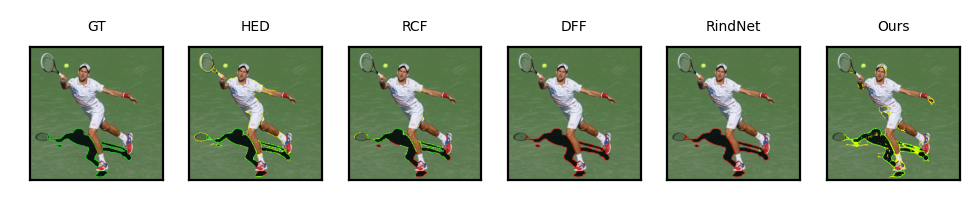

In [35]:




compare_save_path = 'logs/sbu/compare'
gt_save_path = 'logs/sbu/gt'
make_dir(compare_save_path)
make_dir(gt_save_path)

# compare_save_path

threshold_range = [0.5]

best_list = [x[0] for x in best_dict][:30]
for name in best_list:
    
    save_path= join(compare_save_path,name+'.png')

    # if exists(save_path):
    #     continue

    origin_img_path = join(gt_save_path,name+'.png')
    print(origin_img_path)

    # if  exists(origin_img_path):
    #     print('exists')
    #     draw_image = imread(origin_img_path)[:,:,::-1]
    # else:
    #     print('not exists')
    idx = ours_selector.name2idx(name)
    image, gt_edge = ours_selector.get_origin_data(idx)
    draw_image = image[:,:,::-1].copy()
    draw_image[gt_edge==1] = ours_selector.COLORS['TP']
    show_imgs([draw_image],[0],img_name=origin_img_path)

    
    __ours = ours_selector.draw_edge(idx,threshold_range)
    __hed = hed_selector.draw_edge(idx,threshold_range)
    __dff = dff_selector.draw_edge(idx,threshold_range)
    __rcf = rcf_selector.draw_edge(idx,threshold_range)
    __rindnet = rindnet_selector.draw_edge(idx,threshold_range)

    
    image_list = [draw_image] +__hed+__rcf+__dff+__rindnet + __ours
    show_imgs(image_list,[0]*len(image_list),titles=['GT','HED','RCF','DFF','RindNet','Ours'],img_name=save_path)
    
    

    


    

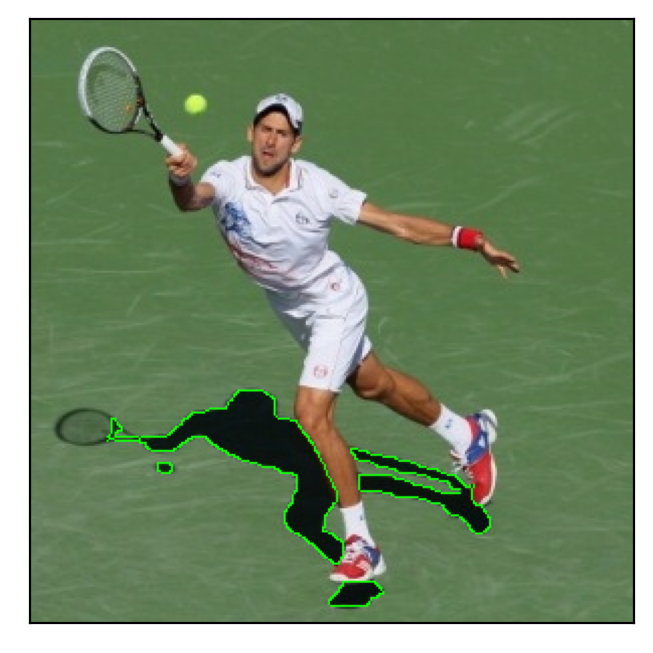

In [36]:
show_imgs([draw_image],[0])

In [37]:
# tmp = load_mat('/home/DISCOVER_summer2022/xusc/exp/Cerberus-main/eval_tools/sbu_image_list.mat')
# tmp = [x.tolist()[0] for x in tmp['ids'].tolist()[0]]
# tmp = [ '.'.join(x.split('.')[:-1]) for x in tmp]
# np.savetxt('data/SBU/SBU-shadow/SBU-Test/matlab_load_sequence.txt',tmp,fmt='%s')